In [1]:
from quantumsim.functions.ansatz import *
from quantumsim.functions.min_methods import *
from quantumsim.functions.funciones import *
from quantumsim.optimizacion_structure import *
from quantumsim.variational_quantum_eigensolver import *

from pennylane import numpy as np

### Spin

In [7]:
sz = np.array([[1,0],[0,-1]])
si = np.array([[1,0],[0,1]])
sx = np.array([[1,0],[0,1]])
sy = np.array([[1,0],[0,1]])

h = -1*( np.kron(sz, sz) + np.kron(sy, sy) + np.kron(sx, sx) )
ee = np.linalg.eigvals(h)
print(ee)

[-3. -1. -1. -3.]


In [8]:
params = {
    "sites": 2,
    "spin": 0.5, 
    "pattern": "open",
    "exchange": [1,1,1]
}

object_vqe = vqe_spin(params)
object_vqe.set_group_characteristics()

In [9]:
ansatz_params = {
    "repetitions": 2,
    "electrons": 2,
    "base": "default.qubit",
    "backend": None,
    "interface": "autograd",
    "shots": 1000.0,
    "token": None,
}

object_vqe.set_device(ansatz_params)
object_vqe.set_node(ansatz_params)

rep = ansatz_params["repetitions"]
number = (object_vqe.qubits)*rep

In [10]:
object_vqe.hamiltonian_object

[['XX'], ['YY'], ['ZZ']]

In [11]:
minimizate_params = {
    "type": "SLSQP",
    "maxiter": 1000,
    "tol": 0.000001,
    "step_theta": 0.4,
    "step_x": 0.8,
    "number": object_vqe.qubits*ansatz_params["repetitions"]}

optimizer = scipy_optimizer(minimizate_params)
optimizer.set_constrains()
theta = np.array( [0.0  for _ in range(object_vqe.qubits*ansatz_params["repetitions"])], requires_grad=True)
energy, optimum = optimizer.VQE(object_vqe.cost_function, theta, object_vqe.qubits)

In [12]:
energy

[tensor(-1., requires_grad=True),
 tensor(-1., requires_grad=True),
 tensor(-1., requires_grad=True),
 tensor(-1., requires_grad=True),
 tensor(-1., requires_grad=True)]

(<Figure size 1200x300 with 1 Axes>, <Axes: >)

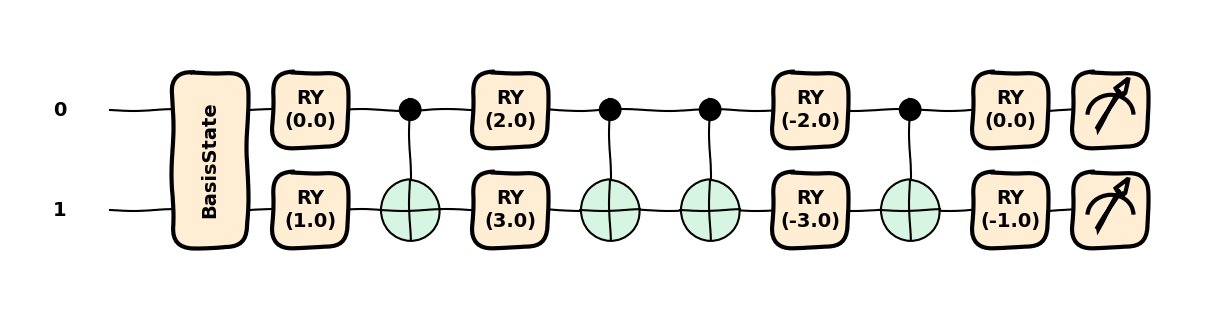

In [13]:
qml.draw_mpl(object_vqe.node_overlap, decimals=1, style="sketch")( [i for i in range(4)], [i for i in range(4)], [0,0,0,0], [0,0,0,0])

In [5]:
ansatz_params = {
    "repetitions": 2,
    "electrons": 2,
    "base": "default.qubit",
    "backend": None,
    "interface": "autograd",
    "shots": 1000.0,
    "token": None,
}

object_vqe.set_device(ansatz_params)
object_vqe.set_node(ansatz_params)

rep = ansatz_params["repetitions"]
number = (object_vqe.qubits)*rep

In [8]:
minimizate_params = {
    "type": "SLSQP",
    "maxiter": 1000,
    "tol": 0.000001,
    "step_theta": 0.4,
    "step_x": 0.8,
    "number": object_vqe.qubits*ansatz_params["repetitions"]}

# Ejecucion del optimizador para calcular los niveles 
# de energia

optimizer = scipy_optimizer(minimizate_params)
optimizer.set_constrains()
theta = np.array( [0.0  for _ in range(object_vqe.qubits*ansatz_params["repetitions"])], requires_grad=True)
energy, optimum = optimizer.VQE(object_vqe.cost_function, theta)

TypeError: circuit() missing 2 required positional arguments: 'characteristic' and 'state'

In [7]:
energy

[tensor(-0.99999975, requires_grad=True),
 tensor(-1., requires_grad=True),
 tensor(0.99999989, requires_grad=True),
 tensor(0.99999917, requires_grad=True)]

In [8]:
theta

[array([3.14138699, 2.20313188, 0.16999992, 2.20242932]),
 array([4.18122105, 1.57079748, 2.27179888, 1.57080014]),
 array([-2.99415959e-04,  3.61409007e-01,  1.94960894e+00, -3.61796839e-01]),
 array([ 1.90530544, -1.56978526,  0.71308162,  1.57026132])]

### Molecular

In [4]:
class variational_quantum_eigensolver_electronic(spin_ansatz):
    hamiltonian_object= None
    mapping= 'jordan_wigner'
    charge= 0
    mult= 1
    basis='sto-3g'
    method='dhf'

    pattern = "chain"
    qubits = 4
    correction = 1
    repetition = 3

    '''
    Iniciador de la clase que construye el hamiltoniano molecular y lo almacena en
    la representación Pauli String.
    input:
        symbols: list [string]
        coordinates: list [float]
        params: dict
    return:
        result: none
    '''
    def __init__(self, symbols, coordinates, params= None):
        if params['mapping']:
            if params['mapping'] in ("jordan_wigner", "bravyi_kitaev"):
                self.mapping = params['mapping']
            else:
                raise Exception("Mapping no valido, considere jordan_wigner o bravyi_kitaev")
            
        if params['charge']:
            self.charge = params['charge']

        if params['mult']:
            self.mult = params['mult']

        if params['basis']:
            if params['basis'] in ("sto-3g", "6-31g", "6-311g", "cc-pvdz"):
                self.basis = params['basis']
            else:
                raise Exception("Base no valida, considere sto-3g, 6-31g, 6-311g, cc-pvdz")
        
        if params['method']:
            if params['method'] in ("pyscf", "dhf"):
                self.method = params['method']
            else:
                raise Exception("Metodo no valido, considere dhf o pyscf")

        
        aux_h, self.qubits = qchem.molecular_hamiltonian(
            symbols= symbols,
            coordinates= coordinates,
            mapping= self.mapping,
            charge= self.charge,
            mult= self.mult,
            basis= self.basis,
            method= self.method)
        
        coeff, expression = aux_h.terms()
        Pauli_terms = []

        for k, term in enumerate(expression):
            string = Pauli_function(term, self.qubits)
            Pauli_terms.append([coeff[k], string])

        self.hamiltonian_object = conmute_group(Pauli_terms)
        return
    
    '''
    Funcion de coste:
    input:
        theta: Lista de parametros ([float])
    return:
        result: Valor esperado (float)
    '''
    def cost_function(self, theta):
        params = theta
        result = 0.0

        #Iteracion sobre grupos conmutantes
        for group in self.hamiltonian_object:
            if is_identity(group[0][1]):
                exchange = group[0][0]
                exchange.requires_grad = True
                result += exchange
            else:
                result_probs = self.node(theta = params, obs = group)
                for k, probs in enumerate(result_probs):
                    exchange = group[k][0]
                    exchange.requires_grad = True
                    for j in range(len(probs)):
                        result += exchange*probs[j]*parity(j)
        return result
    
    def overlap_cost_function(self, theta, theta_overlap):
        result_probs = self.node_overlap(theta = theta, theta_overlap=theta_overlap)
        return result_probs[0]

In [45]:
symbols = ['H', 'H']
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])

H, qubits = qchem.molecular_hamiltonian(symbols, coordinates, wires=[0,1,2,3])

coeff, terms = H.terms()

In [46]:
terms, coeff = qml.pauli.group_observables(observables=terms,coefficients=coeff, grouping_type='qwc', method='rlf')


In [65]:
Pauli_terms = []
for group in terms:
    aux = []
    for term in group:
        string = Pauli_function(term, 4)
        aux.append(string)   
    Pauli_terms.append(aux)

In [66]:
Pauli_terms

[['IIII', 'YXXY'],
 ['YYXX'],
 ['XXYY'],
 ['XYYX'],
 ['ZIII',
  'IZII',
  'ZZII',
  'IIZI',
  'ZIZI',
  'IIIZ',
  'ZIIZ',
  'IZZI',
  'IZIZ',
  'IIZZ']]

In [58]:
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev, interface="autograd")
def circuit(group, **kwargs):
    qml.BasisState([0 for _ in range(4)], wires=range(4))
    return [qml.probs(wires=o.wires) for o in group]

In [60]:
terms[0][0].wires

<Wires = [0]>

In [59]:
circuit(terms[0])

[tensor([1., 0.], requires_grad=True),
 tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)]

In [10]:
si = np.array([[1,0],[0,1]], dtype="complex64")
sz = np.array([[1,0],[0,-1]], dtype="complex64")
sx = np.array([[0,1],[1,0]], dtype="complex64")
sy = np.array([[0,-1j],[1j,0]], dtype="complex64")

H = coeff[0]*np.kron( np.kron(si,si), np.kron(si,si) ) + coeff[1]*np.kron( np.kron(sz,si), np.kron(si,si) ) + coeff[2]*np.kron( np.kron(si,sz), np.kron(si,si) )
H += coeff[3]*np.kron( np.kron(sz,sz), np.kron(si,si) ) + coeff[4]*np.kron( np.kron(sy,sx), np.kron(sx,sy) ) + coeff[5]*np.kron( np.kron(sy,sy), np.kron(sx,sx) )
H += coeff[6]*np.kron( np.kron(sx,sx), np.kron(sy,sy) ) + coeff[7]*np.kron( np.kron(sx,sy), np.kron(sy,sx) ) + coeff[8]*np.kron( np.kron(si,si), np.kron(sz,si) )
H += coeff[9]*np.kron( np.kron(sz,si), np.kron(sz,si) ) + coeff[10]*np.kron( np.kron(si,si), np.kron(si,sz) ) + coeff[11]*np.kron( np.kron(sz,si), np.kron(si,sz) )
H += coeff[12]*np.kron( np.kron(si,sz), np.kron(sz,si) ) + coeff[13]*np.kron( np.kron(si,sz), np.kron(si,sz) ) + coeff[14]*np.kron( np.kron(si,si), np.kron(sz,sz) )

In [5]:
symbols = ['H', 'H']
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])
params = {
    "mapping": "jordan_wigner",
    "charge": 0, 
    "mult": 1,
    "basis": 'sto-3g',
    "method": 'dhf'
}

hamiltonian_object = variational_quantum_eigensolver_electronic(symbols, coordinates, params)

In [6]:
ansatz_params = {
    "repetitions": 3,
    "electrons": 3,
    "base": "default.qubit",
    "backend": None,
    "interface": "autograd",
    "shots": 1000.0,
    "token": None,
}

hamiltonian_object.set_device( ansatz_params )
#hamiltonian_object.set_hiperparams_circuit( ansatz_params )
hamiltonian_object.set_node( ansatz_params )

rep = ansatz_params["repetitions"]

In [13]:
minimizate_params = {
    "type": "SLSQP",
    "maxiter": 100,
    "tol": 0.000001,
    "step_theta": 0.4,
    "step_x": 0.8
}

#energy, theta_evol, theta = gradiend_method_VQE(hamiltonian_object.cost_function, theta, minimizate_params)
energy, optimum = scipy_method_VQD(hamiltonian_object.cost_function, hamiltonian_object.overlap_cost_function, 16, minimizate_params)

In [14]:
np.sort(energy)

tensor([-1.13618892, -0.52188334, -0.52186317, -0.47844685, -0.47843727,
        -0.47821364, -0.4031787 , -0.40317794, -0.12044661,  0.30767533,
         0.30767546,  0.44899833,  0.4490921 ,  0.58332556,  0.75597186,
         1.01609576], requires_grad=True)

In [11]:
np.linalg.eigvalsh(H)

tensor([-1.1361891 , -0.52188355, -0.52188349, -0.47844693, -0.47844693,
        -0.4784469 , -0.40317875, -0.40317875, -0.12044625,  0.30767557,
         0.3076756 ,  0.44909644,  0.4490965 ,  0.58332568,  0.75597221,
         1.01609778], dtype=float32, requires_grad=True)